In [1]:
import cell2cell as c2c
import scanpy as sc
import pandas as pd

%matplotlib inline

# Data

**RNA-seq data**

In this case is a published dataset of ~14000 IFN-beta treated and control PBMCs from 8 donors (GSE96583; see Kang et al.). (obtained from: https://scelvis.readthedocs.io/en/latest/tutorial_analysis.html)

Download this dataset here: https://files.figshare.com/18037739/pbmc.h5ad

In [2]:
rnaseq = sc.read_h5ad('pbmc.h5ad')

In [3]:
rnaseq

AnnData object with n_obs × n_vars = 13836 × 14053
    obs: 'n_genes', 'n_counts', 'orig_ident', 'stim', 'cluster', 'Donor'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled'
    uns: 'about_readme', 'about_short_title', 'about_title', 'marker_avg_logFC', 'marker_cluster', 'marker_gene', 'marker_p_val_adj'
    obsm: 'X_tsne'

**For the purpose of this example, we will inspect only the control condition**

In [4]:
rnaseq = rnaseq[rnaseq.obs.stim == 'CTRL']

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
rnaseq

View of AnnData object with n_obs × n_vars = 6573 × 14053
    obs: 'n_genes', 'n_counts', 'orig_ident', 'stim', 'cluster', 'Donor'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled'
    uns: 'about_readme', 'about_short_title', 'about_title', 'marker_avg_logFC', 'marker_cluster', 'marker_gene', 'marker_p_val_adj'
    obsm: 'X_tsne'

**Protein-Protein Interactions or Ligand-Receptor Pairs**

In this case, we use a list of LR pairs published with CellChat (Jin et al. 2021, Nature Communications).

In [6]:
lr_pairs = pd.read_csv('Human-2020-Jin-LR-pairs.csv')

In [7]:
lr_pairs.head()

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2)
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2)
2,TGFB3_TGFBR1_TGFBR2,TGFb,TGFB3,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB3 - (TGFBR1+TGFBR2)
3,TGFB1_ACVR1B_TGFBR2,TGFb,TGFB1,ACVR1B_TGFbR2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,TGFB1 - (ACVR1B+TGFBR2)
4,TGFB1_ACVR1C_TGFBR2,TGFb,TGFB1,ACVR1C_TGFbR2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,TGFB1 - (ACVR1C+TGFBR2)


**The names of genes/proteins have to match those in the rnaseq dataset.**

So we will make all names to be all capital letters. We will also change the annotation of the complexes to easily integrate the data with cell2cell.

In [8]:
# Change complex annotations
lr_pairs['ligand2'] = lr_pairs.interaction_name_2.apply(lambda x: x.split(' - ')[0].upper())
lr_pairs['receptor2'] = lr_pairs.interaction_name_2.apply(lambda x: x.split(' - ')[1].upper() \
                                                       .replace('(', '').replace(')', '').replace('+', '&'))

lr_pairs['c2c_interaction'] = lr_pairs.apply(lambda row: row['ligand2'] + '^' + row['receptor2'], axis=1)

**Metadata**

Metadata for the single cells

In [9]:
meta = rnaseq.obs.copy()

In [10]:
meta.head()

,n_genes,n_counts,orig_ident,stim,cluster,Donor
index,,,,,,
CTRL_AAACATACATTTCC.1,878.0,3018.0,CTRL,CTRL,CD14 Mono,SNG-1016
CTRL_AAACATACCAGAAA.1,713.0,2481.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACCTCGCT.1,850.0,3420.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACGGCATT.1,558.0,1582.0,CTRL,CTRL,CD14 Mono,SNG-1015
CTRL_AAACATTGCTTCGC.1,669.0,2536.0,CTRL,CTRL,CD14 Mono,SNG-1256


# Cell-cell Interactions and Communication Analysis

**Using an Interaction Pipeline**

The pipeline integrates the RNA-seq and PPI datasets by using the analysis setups. It generates an interaction space containing an instance for each sample/cell type, containing the values assigned to each protein in the PPI list given the setups for computing the CCI and CCC scores.

In this case is single cell data.

In [11]:
interactions = c2c.analysis.SingleCellInteractions(rnaseq_data=rnaseq.to_df().T,
                                                   ppi_data=lr_pairs,
                                                   metadata=meta,
                                                   interaction_columns=('ligand2', 'receptor2'),
                                                   communication_score='expression_thresholding',
                                                   expression_threshold=0.1, # values after aggregation
                                                   cci_score='bray_curtis',
                                                   cci_type='undirected',
                                                   aggregation_method='nn_cell_fraction',
                                                   barcode_col='index',
                                                   celltype_col='cluster',
                                                   complex_sep='&',
                                                   verbose=False)

**Compute communication scores for each PPI or LR pair**

In [12]:
interactions.compute_pairwise_communication_scores()

Computing pairwise communication
Computing communication score between Mk and B activated
Computing communication score between CD14 Mono and CD14 Mono
Computing communication score between B and B activated
Computing communication score between NK and NK
Computing communication score between CD16 Mono and pDC
Computing communication score between CD16 Mono and CD16 Mono
Computing communication score between T activated and CD4 Naive T
Computing communication score between B activated and CD14 Mono
Computing communication score between CD4 Naive T and NK
Computing communication score between NK and CD8 T
Computing communication score between CD4 Memory T and DC
Computing communication score between CD4 Memory T and Mk
Computing communication score between T activated and Eryth
Computing communication score between B and pDC
Computing communication score between B activated and CD4 Memory T
Computing communication score between CD4 Naive T and CD8 T
Computing communication score between

**Compute CCI scores for each pair of cells**

It is computed according to the analysis setups. We computed an undirected Bray-Curtis-like score for each pair, meaning that score(C1, C2) = score(C2, C1).
**Notice that our score is undirected, so for C1 and C2 was not necessary to compute C2 and C1 as happened for the communication scores**

In [13]:
interactions.compute_pairwise_cci_scores()

Computing pairwise interactions
Computing interaction score between CD14 Mono and CD14 Mono
Computing interaction score between B and B activated
Computing interaction score between NK and NK
Computing interaction score between CD16 Mono and pDC
Computing interaction score between CD16 Mono and CD16 Mono
Computing interaction score between B activated and CD14 Mono
Computing interaction score between CD4 Naive T and NK
Computing interaction score between CD4 Memory T and DC
Computing interaction score between CD4 Memory T and Mk
Computing interaction score between B and pDC
Computing interaction score between B activated and CD4 Memory T
Computing interaction score between CD4 Naive T and CD8 T
Computing interaction score between B activated and CD8 T
Computing interaction score between Eryth and Mk
Computing interaction score between CD14 Mono and CD8 T
Computing interaction score between CD14 Mono and NK
Computing interaction score between CD16 Mono and CD4 Naive T
Computing interact

**Perform permutation analysis**

In [14]:
cci_pvals = interactions.permute_cell_labels(evaluation='interactions', 
                                             permutations=10, 
                                             fdr_correction=False,
                                             verbose=True)

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


In [15]:
cci_pvals

,B,B activated,CD14 Mono,CD16 Mono,CD4 Memory T,CD4 Naive T,CD8 T,DC,Eryth,Mk,NK,T activated,pDC
B,0.1,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2
B activated,0.2,0.8,0.6,0.2,0.1,0.1,0.2,0.6,1.0,0.4,0.4,0.1,0.6
CD14 Mono,0.1,0.6,0.1,0.1,0.6,0.1,0.4,0.1,0.1,0.4,0.1,0.1,0.8
CD16 Mono,0.1,0.2,0.1,0.1,0.2,0.1,0.1,0.1,0.6,0.1,0.2,0.1,0.6
CD4 Memory T,0.1,0.1,0.6,0.2,0.1,0.1,0.1,0.6,0.1,0.1,0.1,0.1,0.6
CD4 Naive T,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.4
CD8 T,0.1,0.2,0.4,0.1,0.1,0.1,0.1,0.4,0.1,0.1,0.1,0.1,0.2
DC,0.1,0.6,0.1,0.1,0.6,0.1,0.4,0.1,0.1,0.4,0.1,0.1,0.4
Eryth,0.1,1.0,0.1,0.6,0.1,0.1,0.1,0.1,0.6,0.2,0.1,0.1,0.8
Mk,0.1,0.4,0.4,0.1,0.1,0.1,0.1,0.4,0.2,0.1,0.1,0.1,0.6


In [16]:
ccc_pvals = interactions.permute_cell_labels(evaluation='communication',
                                             permutations=10, 
                                             fdr_correction=False,
                                             verbose=True)

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


In [17]:
ccc_pvals

,Mk;B activated,CD14 Mono;CD14 Mono,B;B activated,NK;NK,CD16 Mono;pDC,CD16 Mono;CD16 Mono,T activated;CD4 Naive T,B activated;CD14 Mono,CD4 Naive T;NK,NK;CD8 T,...,CD4 Memory T;T activated,CD8 T;DC,T activated;DC,Eryth;CD14 Mono,pDC;Mk,CD14 Mono;Eryth,CD4 Naive T;CD4 Memory T,DC;pDC,Eryth;NK,T activated;B activated
"(TGFB1, TGFBR1&TGFBR2)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(TGFB2, TGFBR1&TGFBR2)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(TGFB1, ACVR1B&TGFBR2)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(TGFB1, ACVR1C&TGFBR2)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(TGFB2, ACVR1B&TGFBR2)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(SEMA7A, ITGB1&ITGA1)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(SEMA7A, PLXNC1)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(SIGLEC1, SPN)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
"(ITGA4, ITGB1&VCAM1)",0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


# Visualizations

If we want to save the figure as a vector figure, we can pass a pathname into the filename input to save it. E.g. ***filename='/Users/cell2cell/CommScores.svg'***

**Generate a metadata for the cell types**

In [18]:
group_meta = pd.DataFrame(columns=['Celltype', 'Group'])
group_meta['Celltype'] = meta['cluster'].unique().tolist()
group_meta['Group'] = ['Mono', 'DC', 'T', 'T', 'T', 'T', 'Mk', 'B', 'B', 'DC', 'Mono', 'NK', 'Eryth']

In [19]:
group_meta

,Celltype,Group
0,CD14 Mono,Mono
1,pDC,DC
2,CD4 Memory T,T
3,T activated,T
4,CD4 Naive T,T
5,CD8 T,T
6,Mk,Mk
7,B activated,B
8,B,B
9,DC,DC


**Generate colors for the groups in the metadata**

It returns a dictionary with the colors.

In [20]:
colors = c2c.plotting.get_colors_from_labels(labels=group_meta['Group'].unique().tolist(),
                                             cmap='tab10'
                                            )

**Visualize communication scores for each LR pair and each cell pair**

Interaction space detected as a Interactions class


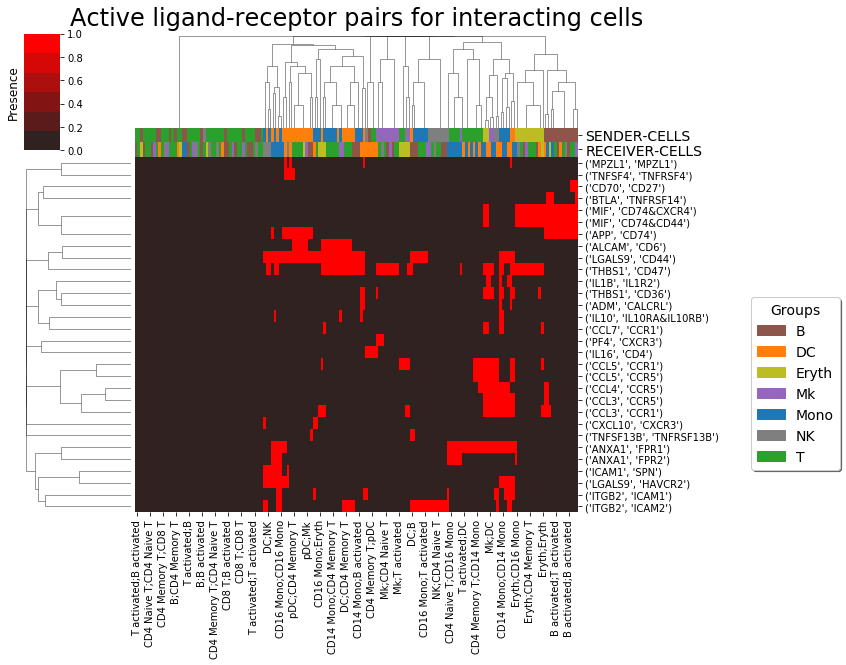

In [21]:
interaction_clustermap = c2c.plotting.clustermap_ccc(interactions,
                                                     metric='jaccard',
                                                     method='complete',
                                                     metadata=group_meta,
                                                     sample_col='Celltype',
                                                     group_col='Group',
                                                     colors=colors,
                                                     row_fontsize=14,
                                                     title='Active ligand-receptor pairs for interacting cells',
                                                     filename=None,
                                                     cell_labels=('SENDER-CELLS', 'RECEIVER-CELLS'),
                                                     **{'figsize' : (10,9)}
                                                     )

# Add a legend to know the groups of the sender and receiver cells:
l1 = c2c.plotting.generate_legend(color_dict=colors,
                                  loc='center left',
                                  bbox_to_anchor=(20, -2), # Indicated where to include it
                                  ncol=1, fancybox=True,
                                  shadow=True,
                                  title='Groups',
                                  fontsize=14,
                                 )

**Circos plot**

It generates a circos plot, showing the cells producing ligands (sender_cells), according to a list of specific ligands (ligands) to the cells producing receptors (receiver_cells), according to a list of specific receptors (receptors). The order of these lists is preserved in the visualization. Elements that are not used are omitted and therefore not plotted (in this case those with a communication score of 0, specified in 'excluded_score').

In [22]:
sender_cells = ['DC', 'pDC']
receiver_cells = ['CD8 T', 'CD4 Memory T', 'B activated']
ligands = ['TGFB1',
           'APP',
           'MIF',
           'CCL3'
          ]
receptors = ['TGFBR1&TGFBR2',
             'CD74&CD44',
             'CD74',
             'CCR1',
            ]

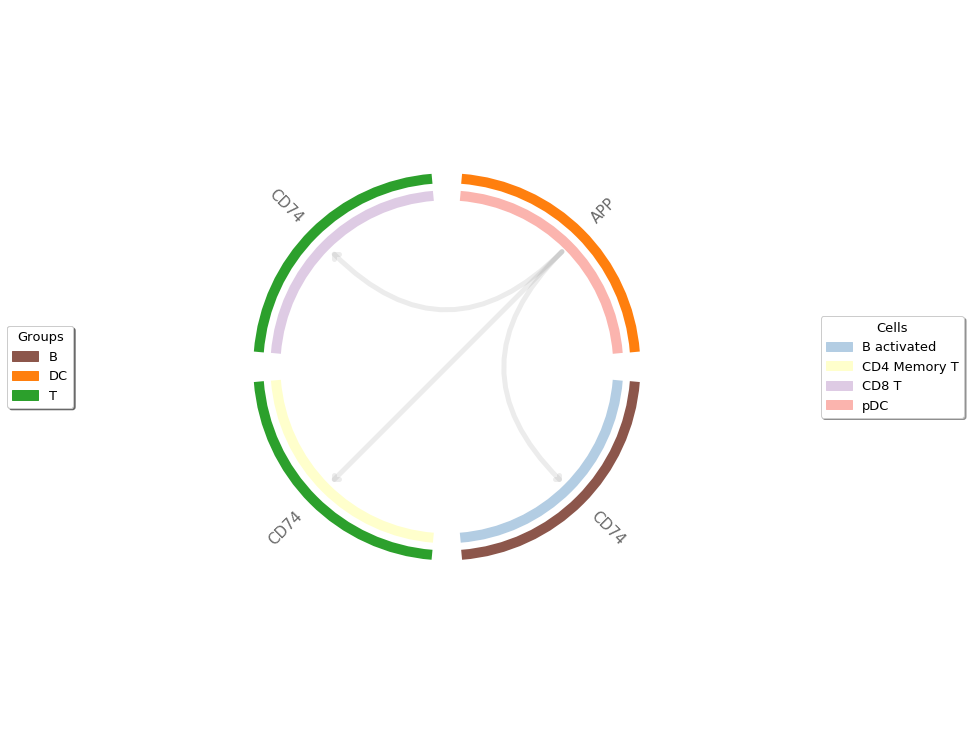

In [23]:
c2c.plotting.circos_plot(interaction_space=interactions,
                         sender_cells=sender_cells,
                         receiver_cells=receiver_cells,
                         ligands=ligands,
                         receptors=receptors,
                         excluded_score=0,
                         metadata=group_meta,
                         sample_col='Celltype',
                         group_col='Group',
                         colors=colors,
                         fontsize=15,
                        )

If we do not pass metadata info, the samples/cell types are only plotted.

We can also change the label colors of ligands and receptors

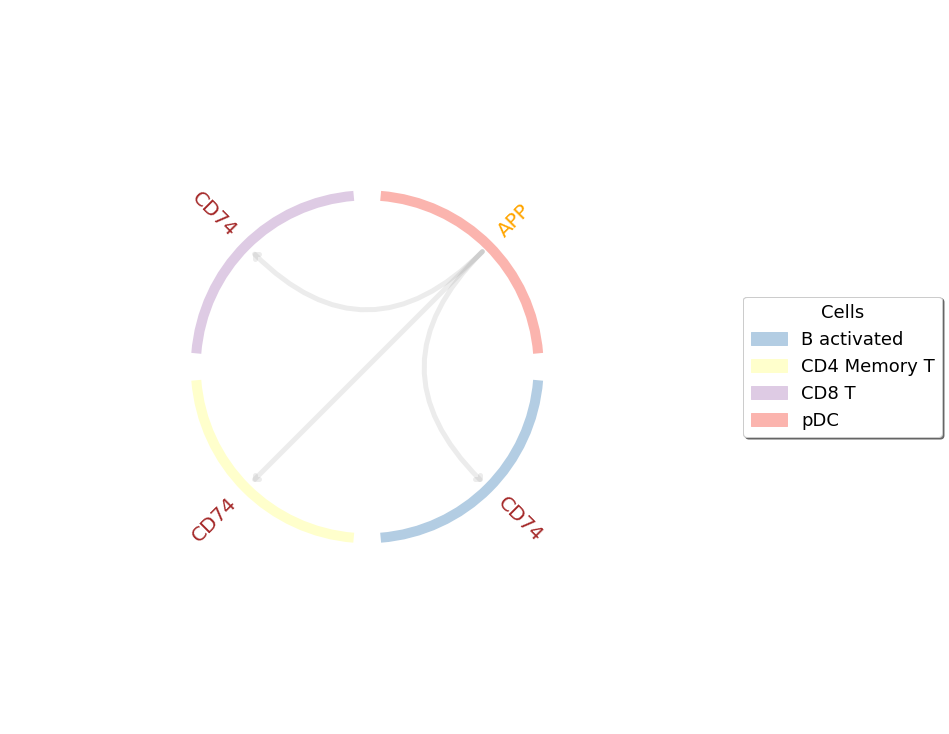

In [24]:
c2c.plotting.circos_plot(interaction_space=interactions,
                         sender_cells=sender_cells,
                         receiver_cells=receiver_cells,
                         ligands=ligands,
                         receptors=receptors,
                         excluded_score=0,
                         fontsize=20,
                         ligand_label_color='orange',
                         receptor_label_color='brown',
                        )

**Dot plot for significance**

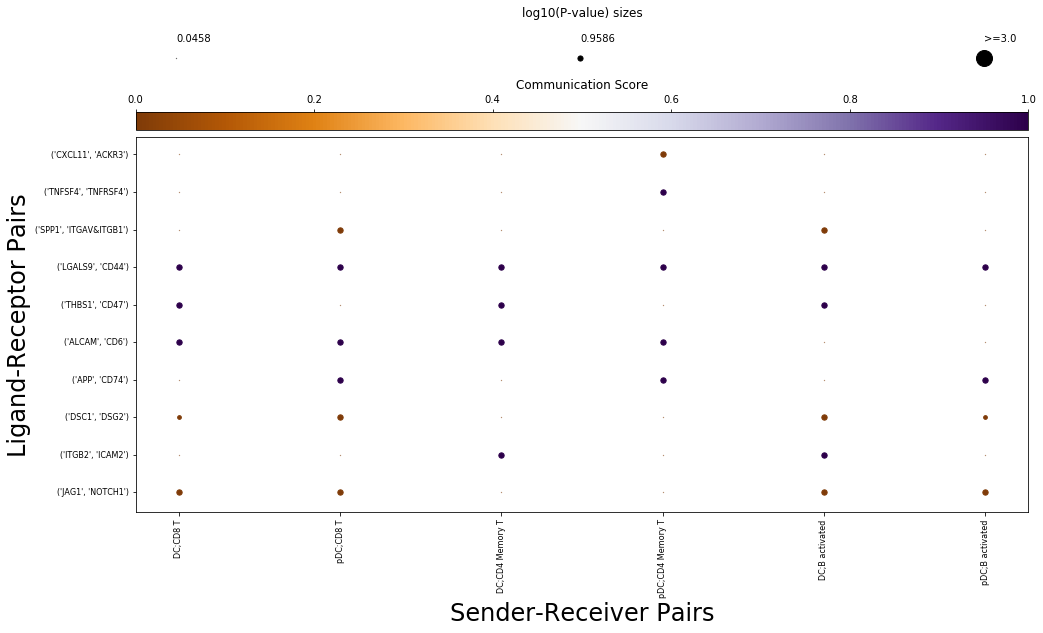

In [25]:
fig = c2c.plotting.dot_plot(interactions,
                            evaluation='communication',
                            significance = 0.11,
                            figsize=(16, 9),
                            cmap='PuOr',
                            senders=sender_cells,
                            receivers=receiver_cells
                            )

**Visualize CCI scores**

Since this case is undirected, a triangular heatmap is plotted instead of the complete one.

Interaction space detected as a Interactions class


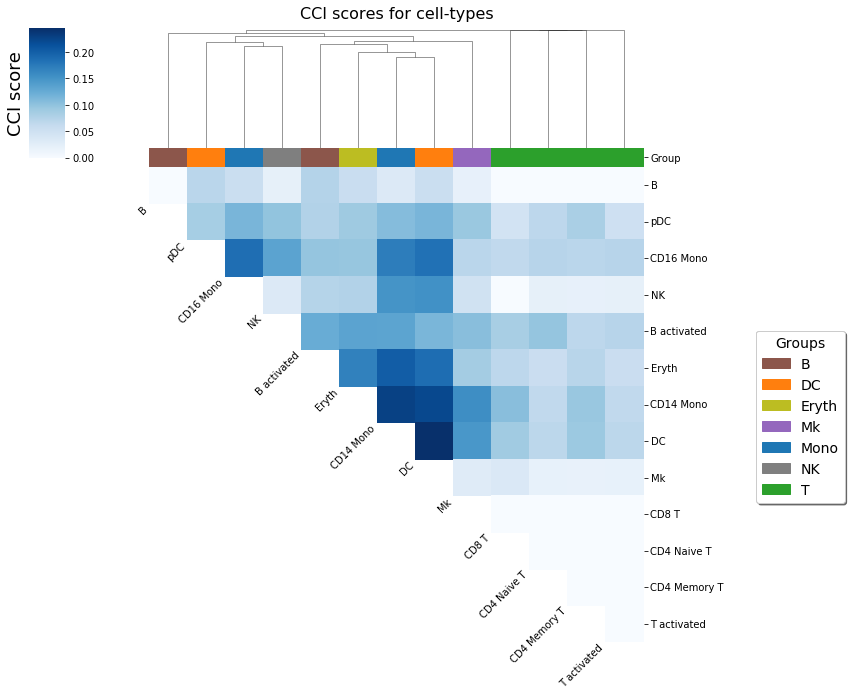

In [26]:
cm = c2c.plotting.clustermap_cci(interactions,
                                 method='complete',
                                 metadata=group_meta,
                                 sample_col="Celltype",
                                 group_col="Group",
                                 colors=colors,
                                 title='CCI scores for cell-types',
                                 cmap='Blues'
                                 )

# Add a legend to know the groups of the sender and receiver cells:
l1 = c2c.plotting.generate_legend(color_dict=colors,
                                  loc='center left',
                                  bbox_to_anchor=(20, -2), # Indicated where to include it
                                  ncol=1, fancybox=True,
                                  shadow=True,
                                  title='Groups',
                                  fontsize=14,
                                 )

**Dot plot for significance**

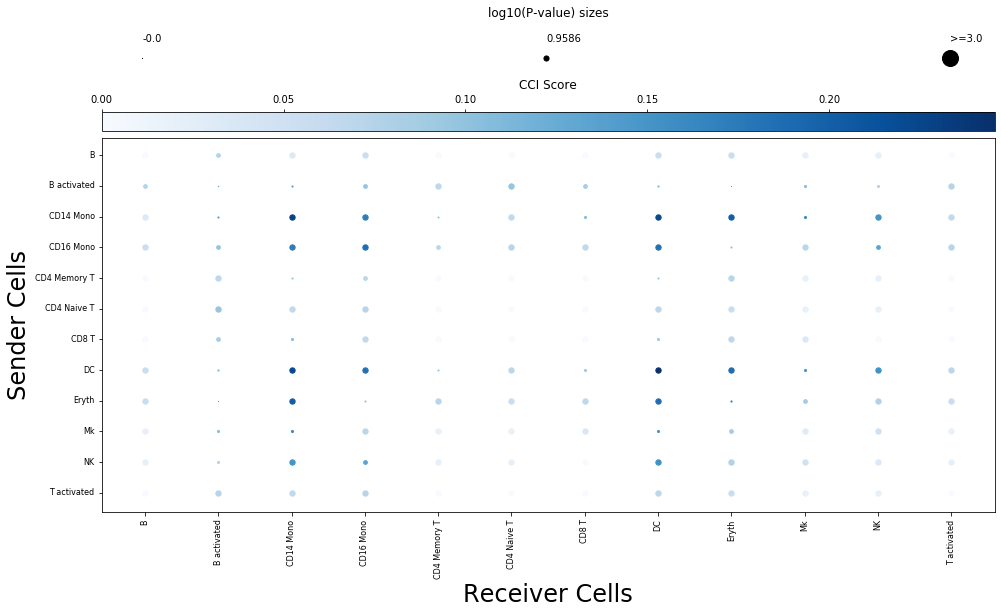

In [29]:
fig = c2c.plotting.dot_plot(interactions,
                            evaluation='interactions',
                            significance = 0.11,
                            figsize=(16, 9),
                            cmap='Blues',
                            )

**Project samples/cells with PCoA into a Euclidean space**

We can project the samples/cells given their CCI scores with other cells and see how close they are given their potential of interaction.

**THIS ONLY WORKS WITH UNDIRECTED CCI SCORES**

Interaction space detected as a Interactions class


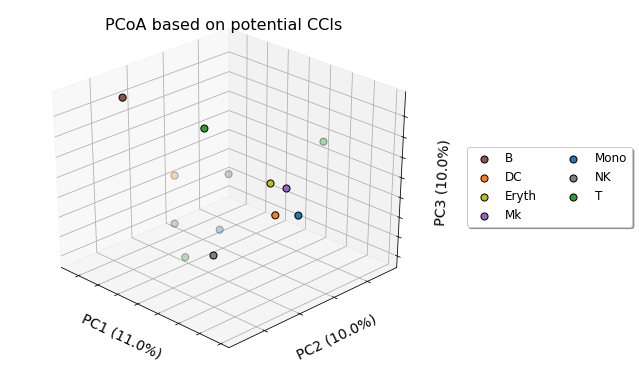

In [27]:
if interactions.analysis_setup['cci_type'] == 'undirected':
        
    pcoa = c2c.plotting.pcoa_3dplot(interactions,
                                    metadata=group_meta,
                                    sample_col="Celltype",
                                    group_col="Group",
                                    title='PCoA based on potential CCIs',
                                    colors=colors,
                                    )

Without metadata

Interaction space detected as a Interactions class


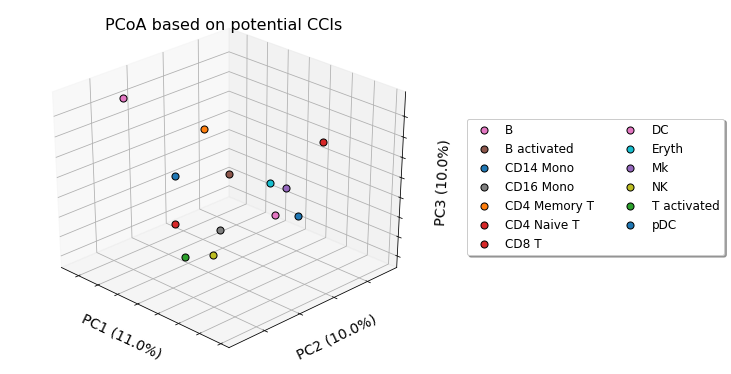

In [28]:
if interactions.analysis_setup['cci_type'] == 'undirected':
    celltype_colors = c2c.plotting.get_colors_from_labels(labels=meta['cluster'].unique().tolist(),
                                                          cmap='tab10'
                                                         )    
    pcoa = c2c.plotting.pcoa_3dplot(interactions,
                                    title='PCoA based on potential CCIs',
                                    colors=celltype_colors,
                                    )